In [1]:
import numpy as np
import json
import pandas as pd
import pathlib
import os
from tqdm.auto import tqdm
import tensorflow as tf
import PIL
import PIL.Image
import matplotlib.pyplot as plt

from sklearn import metrics

2025-01-21 10:23:05.315467: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-21 10:23:05.327193: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1737435185.340559   42161 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1737435185.344290   42161 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-21 10:23:05.358882: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [2]:
physical_devices = tf.config.list_physical_devices('GPU')
try:
  tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
  # Invalid device or cannot modify virtual devices once initialized.
  pass

policy = tf.keras.mixed_precision.Policy('mixed_float16')
tf.keras.mixed_precision.set_global_policy(policy)

In [3]:
parent_directory = "parasite-dataset"

# Initialize empty lists to store image paths and class names
image_paths = []
class_names = []

# Iterate through subfolders (classes)
for class_name in tqdm(os.listdir(parent_directory)):
    class_path = os.path.join(parent_directory, class_name)
    
    # Check if the item is a directory (to exclude files)
    if os.path.isdir(class_path):
        for image_name in os.listdir(class_path):
            # Assuming the image files have a common extension like '.jpg', adjust accordingly
            if image_name.endswith('.jpg'):
                image_path = os.path.join(class_path, image_name)
                
                # Append the image path and class name to the lists
                image_paths.append(image_path)
                class_names.append(class_name)

# Create a DataFrame
df = pd.DataFrame({'Image_Path': image_paths, 'Class_Name': class_names})

# Display the DataFrame
print(df.head())

  0%|          | 0/9 [00:00<?, ?it/s]

                                   Image_Path Class_Name
0  parasite-dataset/Babesia/0109_141708_1.jpg    Babesia
1  parasite-dataset/Babesia/0109_141738_1.jpg    Babesia
2  parasite-dataset/Babesia/0109_141738_2.jpg    Babesia
3  parasite-dataset/Babesia/0109_141738_3.jpg    Babesia
4  parasite-dataset/Babesia/0109_141738_4.jpg    Babesia


In [4]:
df['Class_Name'].value_counts()

Class_Name
Trichomonad    10134
RBCs            8995
Toxoplasma      2933
Leishmania      2701
Trypanosome     2385
Babesia         1173
Leukocyte       1084
Plasmodium       843
Name: count, dtype: int64

In [5]:
batch_size = 64
IMG_SIZE = (224,224)
epochs = 50
early_stop_patience = 10

In [6]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255, validation_split=0.2)  # Adjust preprocessing as needed


train_df = df.sample(frac=0.8, random_state=42)
test_df = df.drop(train_df.index)


train_generator = datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='Image_Path',
    y_col='Class_Name',
    target_size=IMG_SIZE,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)


validation_generator = datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='Image_Path',
    y_col='Class_Name',
    target_size=IMG_SIZE,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)


test_generator = datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='Image_Path',
    y_col='Class_Name',
    target_size=IMG_SIZE,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)


images, labels = next(train_generator)
print(images.shape)
print(labels.shape)

Found 19359 validated image filenames belonging to 8 classes.
Found 4839 validated image filenames belonging to 8 classes.
Found 6050 validated image filenames belonging to 8 classes.
(64, 224, 224, 3)
(64, 8)


In [7]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(224, 224, 3)),
    tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
    tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
    tf.keras.layers.Conv2D(512, 3, padding='same', activation='relu'),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(8, activation='softmax')
])

model.summary()

I0000 00:00:1737435187.646425   42161 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6195 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 128)  │        36,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 512)    │       590,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 8)              │           264 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 663,784 (2.53 MB)

 Trainable params: 663,592 (2.53 MB)

 Non-trainable params: 192 (768.00 B)

In [8]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

In [9]:
from sklearn.utils.class_weight import compute_class_weight

In [10]:
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(train_generator.classes), y=train_generator.classes)

In [11]:
class_weight_dict = dict(enumerate(class_weights))

In [13]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=early_stop_patience, restore_best_weights=True)

history = model.fit(
    train_generator,
    epochs=epochs,
    callbacks=[early_stopping],
    validation_data=validation_generator, class_weight=class_weight_dict)

Epoch 1/50


/home/partha/miniconda3/envs/tflow/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1737435241.926718   42328 service.cc:148] XLA service 0x7fa2cc006cc0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1737435241.926772   42328 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Laptop GPU, Compute Capability 8.9
2025-01-21 10:24:01.987004: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1737435242.262740   42328 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-01-21 10:24:08.605430

  2/303 ━━━━━━━━━━━━━━━━━━━━ 22s 76ms/step - accuracy: 0.0391 - loss: 2.4427 - precision: 0.0000e+00 - recall: 0.0000e+00   

I0000 00:00:1737435266.074130   42328 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


116/303 ━━━━━━━━━━━━━━━━━━━━ 12s 66ms/step - accuracy: 0.1856 - loss: 2.3838 - precision: 0.2351 - recall: 0.0467

2025-01-21 10:24:38.967954: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f16[128,3,3,32]{3,2,1,0}, u8[0]{0}) custom-call(f16[31,112,112,32]{3,2,1,0}, f16[31,112,112,128]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=b01f_o01i->b01f, custom_call_target="__cudnn$convBackwardFilter", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]} is taking a while...
2025-01-21 10:24:39.832720: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.864822867s
Trying algorithm eng0{} for conv (f16[128,3,3,32]{3,2,1,0}, u8[0]{0}) custom-call(f16[31,112,112,32]{3,2,1,0}, f16[31,112,112,128]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=b01f_o01i->b01f, custom_call_target="__cudnn$convBackwardFilter", backend_config={"cudnn_conv_backend_config":{

303/303 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.3055 - loss: 2.0327 - precision: 0.3797 - recall: 0.0899

2025-01-21 10:24:56.038982: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_156', 12 bytes spill stores, 12 bytes spill loads

2025-01-21 10:25:03.791801: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_156', 8 bytes spill stores, 8 bytes spill loads



303/303 ━━━━━━━━━━━━━━━━━━━━ 67s 133ms/step - accuracy: 0.3060 - loss: 2.0313 - precision: 0.3803 - recall: 0.0902 - val_accuracy: 0.3672 - val_loss: 1.9015 - val_precision: 0.5815 - val_recall: 0.3251
Epoch 2/50
303/303 ━━━━━━━━━━━━━━━━━━━━ 24s 79ms/step - accuracy: 0.6885 - loss: 0.9339 - precision: 0.7880 - recall: 0.5120 - val_accuracy: 0.4621 - val_loss: 1.8484 - val_precision: 0.5639 - val_recall: 0.3986
Epoch 3/50
303/303 ━━━━━━━━━━━━━━━━━━━━ 24s 79ms/step - accuracy: 0.7698 - loss: 0.6359 - precision: 0.8258 - recall: 0.6830 - val_accuracy: 0.7435 - val_loss: 0.7053 - val_precision: 0.7794 - val_recall: 0.6520
Epoch 4/50
303/303 ━━━━━━━━━━━━━━━━━━━━ 24s 79ms/step - accuracy: 0.8371 - loss: 0.4612 - precision: 0.8677 - recall: 0.7875 - val_accuracy: 0.9409 - val_loss: 0.2726 - val_precision: 0.9545 - val_recall: 0.9184
Epoch 5/50
303/303 ━━━━━━━━━━━━━━━━━━━━ 25s 79ms/step - accuracy: 0.8621 - loss: 0.4027 - precision: 0.8841 - recall: 0.8310 - val_accuracy: 0.8878 - val_loss: 0.

In [14]:
pred = model.predict(test_generator, batch_size=batch_size)

2025-01-21 10:46:16.215506: E tensorflow/core/util/util.cc:131] oneDNN supports DT_HALF only on platforms with AVX-512. Falling back to the default Eigen-based implementation if present.


94/95 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step

2025-01-21 10:46:22.289436: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_103', 8 bytes spill stores, 8 bytes spill loads



95/95 ━━━━━━━━━━━━━━━━━━━━ 8s 82ms/step


In [15]:
cm = metrics.confusion_matrix(pred.argmax(1), test_generator.classes)

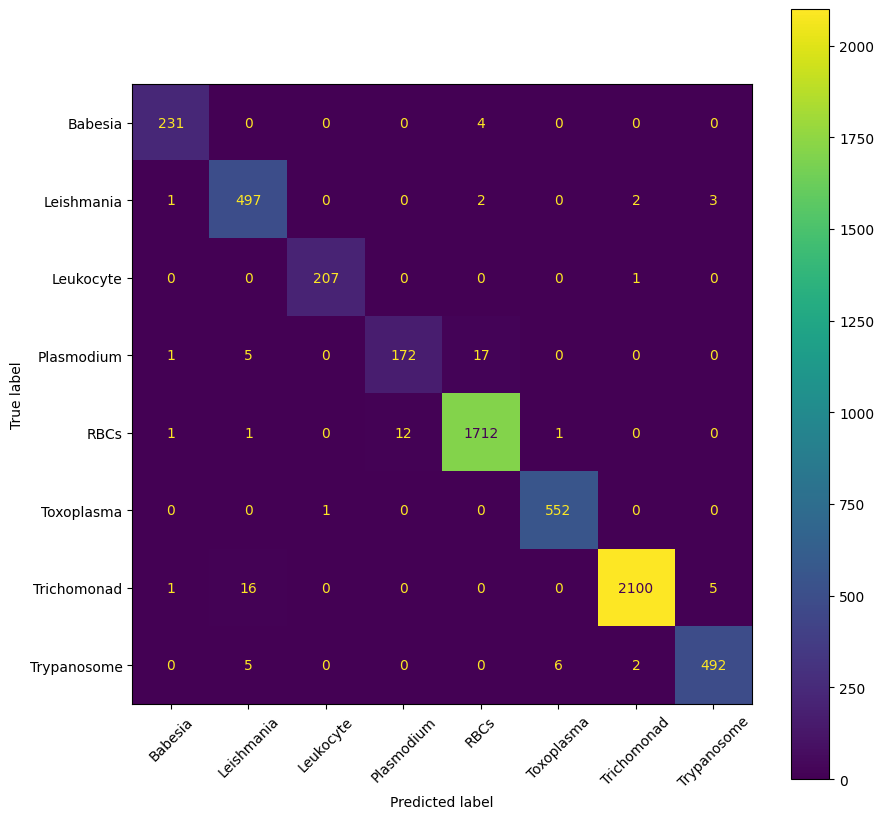

In [16]:
cmp = metrics.ConfusionMatrixDisplay(cm, display_labels=test_generator.class_indices)
fig, ax = plt.subplots(figsize=(10,10))
cmp.plot(ax=ax);
plt.xticks(rotation=45);

In [16]:
train_images, train_labels = next(test_generator)

In [17]:
predictions_batch = model.predict(train_images, verbose=0)

predicted_class_indices_batch = np.argmax(predictions_batch, axis=1)
class_labels = {v: k for k, v in test_generator.class_indices.items()}
predicted_class_labels_batch = [class_labels[idx] for idx in predicted_class_indices_batch]

num_images = len(train_images)
num_rows = int(np.ceil(num_images / 4))
num_cols = min(num_images, 4)

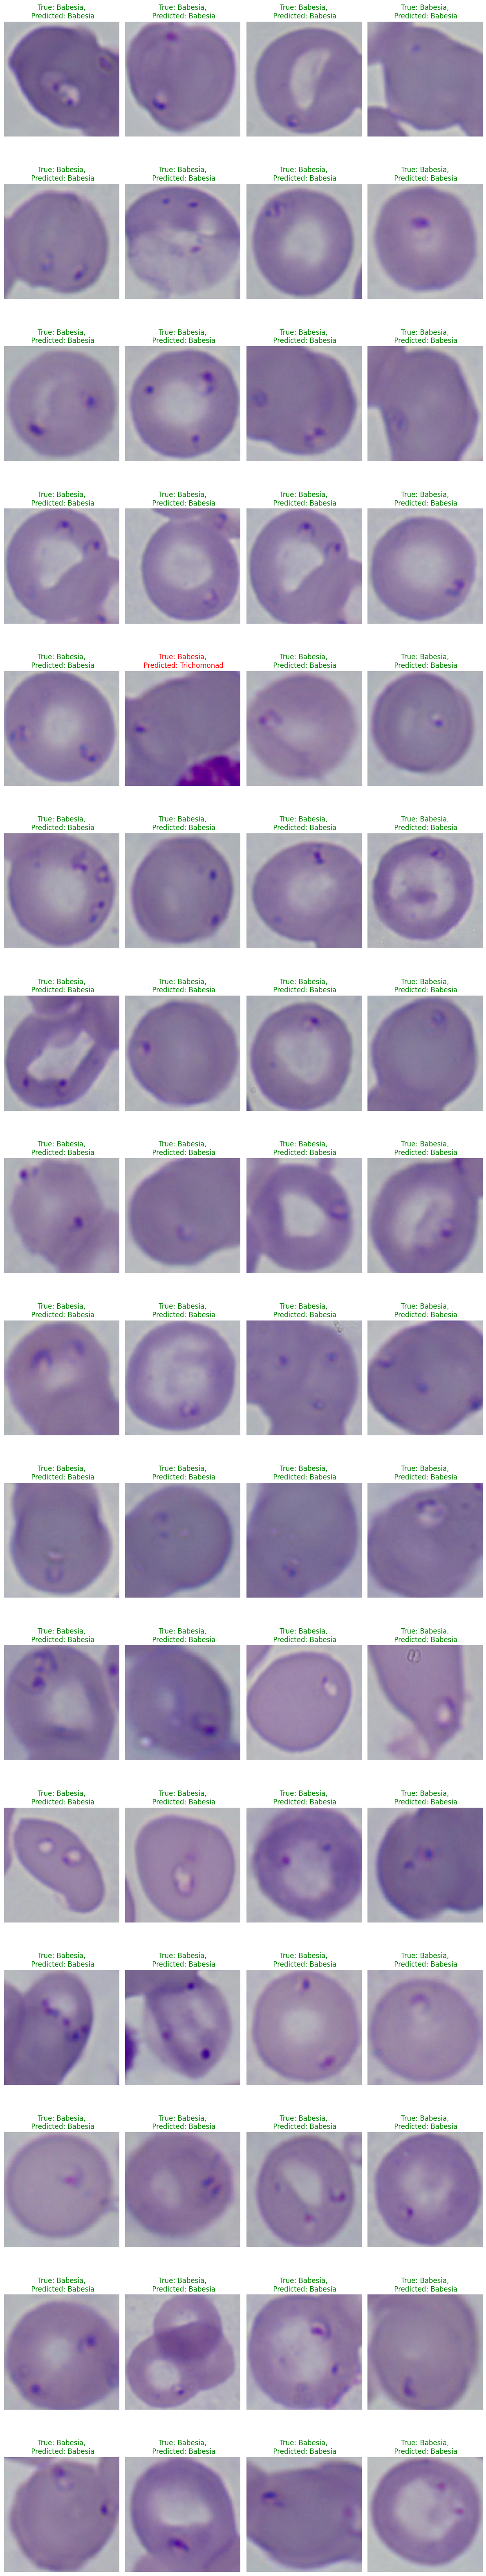

In [18]:
plt.figure(figsize=(12, 4 * num_rows))
for i in range(num_images):
    plt.subplot(num_rows, num_cols, i + 1)
    plt.imshow(train_images[i])
    
    # Set title color based on the correctness of prediction
    title_color = 'green' if predicted_class_labels_batch[i] == class_labels[np.argmax(train_labels[i])] else 'red'
    
    plt.title(f'True: {class_labels[np.argmax(train_labels[i])]},\n Predicted: {predicted_class_labels_batch[i]}', color=title_color)
    plt.axis('off')

plt.tight_layout()
plt.show()

In [17]:
print(metrics.classification_report(test_generator.classes, pred.argmax(1), target_names=test_generator.class_indices.keys()))

              precision    recall  f1-score   support

     Babesia       0.98      0.98      0.98       235
  Leishmania       0.98      0.95      0.97       524
   Leukocyte       1.00      1.00      1.00       208
  Plasmodium       0.88      0.93      0.91       184
        RBCs       0.99      0.99      0.99      1735
  Toxoplasma       1.00      0.99      0.99       559
 Trichomonad       0.99      1.00      0.99      2105
 Trypanosome       0.97      0.98      0.98       500

    accuracy                           0.99      6050
   macro avg       0.97      0.98      0.98      6050
weighted avg       0.99      0.99      0.99      6050



In [18]:
model.save("parasite-detector.h5")

In [19]:
with open("class_label_mappings.json", "w") as f:
    json.dump(test_generator.class_indices, f, indent=4)